# DATASCI 3ML3 - Final Project

Bianca Ha - 400238370 - hab6

## Background

Database source: https://archive.ics.uci.edu/dataset/759/glioma+grading+clinical+and+mutation+features+dataset. <br>

Gliomas are a type of brain tumor, and can be classified as lower-grade-glioma (LGG) or glibolastoma multiforme (GBM). This dataset contains 839 instances of data, labelled as LGG (0), or GBM (1), with 23 features. 20 of the features are the most commonly found mutated genes, denoted by 0 for not mutated, and 1 for mutated, as well as 3 clinical descriptors: gender (coded as 0 for male, 1 for female), age at diagnosis (continuous, in years), and race. There is no missing data in this database. <br>

**Goal:** To develop a model that can categorize tumors as LGG or GBM. The database source suggests using a 10-fold cross validation. 

## Data Visualization

Importing the data and related libraries for data visualization, to get a sense of general data distribution.

In [179]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
from autograd import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# fetch dataset 
glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759) 
  
# data (as pandas dataframes) 
X = glioma_grading_clinical_and_mutation_features.data.features 
y = glioma_grading_clinical_and_mutation_features.data.targets 

In [163]:
print(X)

     Gender  Age_at_diagnosis                       Race  IDH1  TP53  ATRX  \
0         0             51.30                      white     1     0     0   
1         0             38.72                      white     1     0     0   
2         0             35.17                      white     1     1     1   
3         1             32.78                      white     1     1     1   
4         0             31.51                      white     1     1     1   
..      ...               ...                        ...   ...   ...   ...   
834       1             77.89                      white     0     0     0   
835       0             85.18                      white     0     1     0   
836       1             77.49                      white     0     1     0   
837       0             63.33                      white     0     1     0   
838       0             76.61  black or african american     0     0     0   

     PTEN  EGFR  CIC  MUC16  ...  FUBP1  RB1  NOTCH1  BCOR  CSM

In [165]:
# extracting based on glioma type, keeping binary values only
LGG=(pd.DataFrame(X[y['Grade']==0])).drop(['Race','Age_at_diagnosis'],axis=1)
GBM=(pd.DataFrame(X[y['Grade']==1])).drop(['Race','Age_at_diagnosis'],axis=1)

Text(0.5, 1.0, 'GBM')

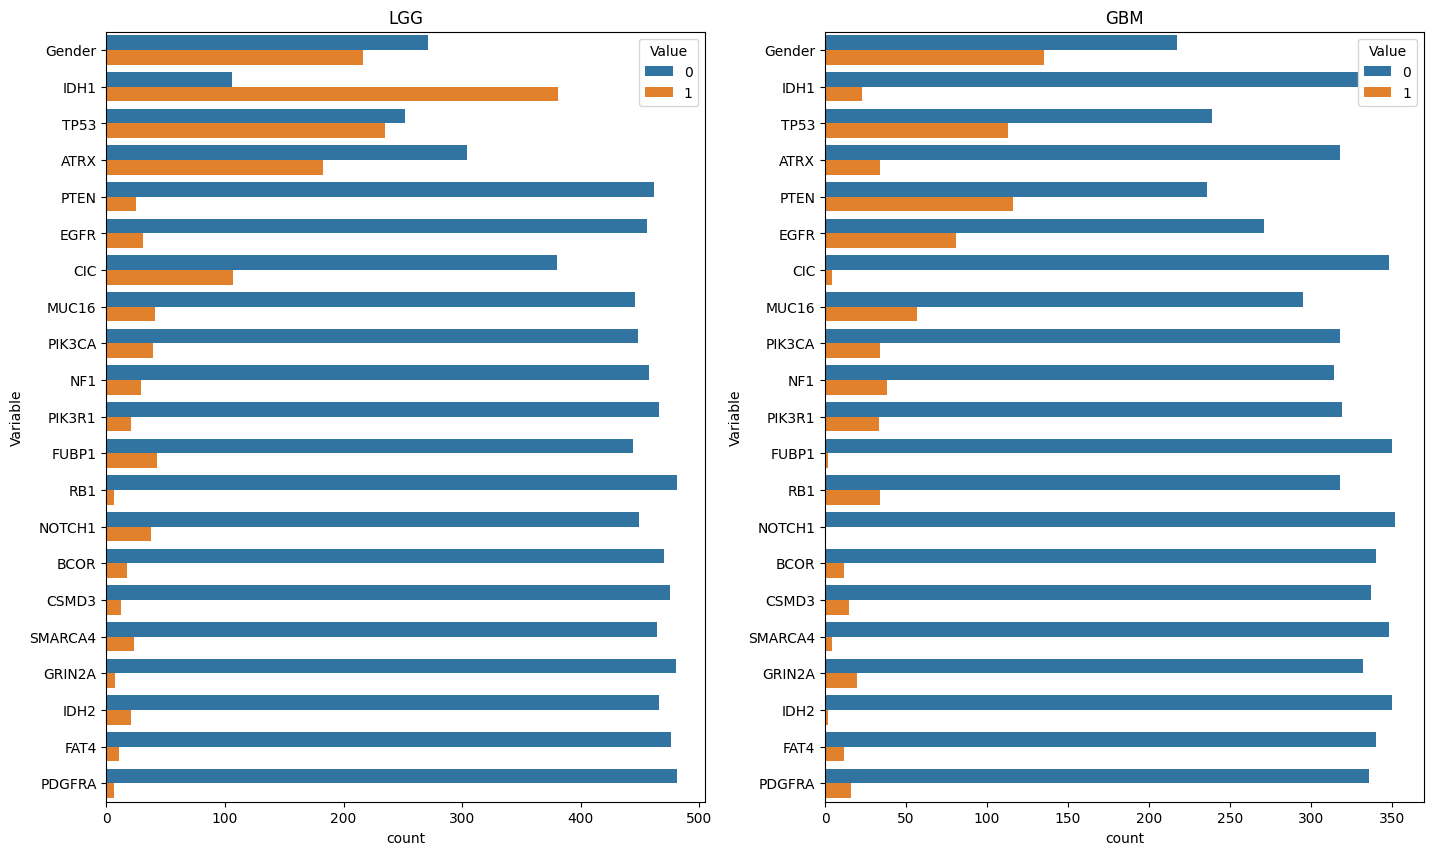

In [166]:
LGG2=LGG.melt(var_name='Variable',value_name='Value')
GBM2=GBM.melt(var_name='Variable',value_name='Value')

# plot
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(17, 10))
sns.countplot(y='Variable',hue='Value',data=LGG2,ax=ax1)
sns.countplot(y='Variable',hue='Value',data=GBM2,ax=ax2)
ax1.set_title('LGG')
ax2.set_title('GBM')

From visual inspection of the figures above, it can be noted that the mutated version of IDH1 is much more prevalent in LGG than GBM. The proportion of mutated TP53 and ATRX is also larger in LGG. On the other hand, mutated PTEN and EGFR is seen more (proportionally) in GBM. It is important to note that there is also a sizable difference in sample size between LGG and GBM data (just under 500, and around 350, respectively).

## Data Preparation

In [270]:
print(X['Race'].value_counts())

Race
white                               765
black or african american            59
asian                                14
american indian or alaska native      1
Name: count, dtype: int64


As shown above, it can be seen that the distribution of race data is heavily skewed to white, and training a model in this data may not be appropriate, thus this feature is removed. Age at diagnosis was also removed, and the model focused only on binary data (the genetic mutations and gender). The data is currently in pandas dataframe form, so it was converted to numpy arrays, and the data was split to be used 70% for training, 30% for validation.

In [180]:
from sklearn.model_selection import train_test_split
X2=X.drop(['Race','Age_at_diagnosis'],axis=1)

X_arr=X2.to_numpy()
y_arr=y.to_numpy()

print(X_arr.shape)
print(y_arr.shape)

# using built in function to randomly create testing and training splits
x_train, x_valid, y_train, y_valid = train_test_split(X_arr, y_arr, test_size=0.3, shuffle= True)
print(x_train.shape)
print(y_train.shape)


(839, 21)
(839, 1)
(587, 21)
(587, 1)


## Model Building

In [32]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

Two models were constructed, below, using different optimizers. Both were tuned to maximize accuracy and minimize losses, plotted below. Both models use two dense layers (which was determined after testing and based on when adding layers stopped improving the model), with the first using 21 neurons (equal to the number of features), and an output neuron with 1 neuron (since the output has dimension of 1). ReLu activation was chosen since it is less likely to result in a vanishing gradient. The sigmoid activation was used as the last layer, over softmax, since this is a binary classification. 

In [239]:
model=Sequential([Dense(21,activation='relu'),Dense(1,activation='sigmoid')])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics='accuracy')
history=model.fit(x=x_train,y=y_train,batch_size=64,validation_data=(x_valid,y_valid),epochs=75,shuffle=True,verbose=0)

The Adam optimizer was chosen since it is computationally pretty efficient and can handle large number of parameters well. It is based on the combination of AdaGrad and RMSProp [1]. The Adam optimizer has a few advantages: the magnitudes of parameters updates do not vary based on how the gradient rescales, the stepsizes are bounded by the stepsize hyperparameter and works well with sparse gradients [1]. The number of epochs was limited to when the loss/accuracy stopped improving, and batch size was chosen such that it wasn't too small to become noisy, while allowing convergence. 

Text(619.9949494949494, 0.5, 'Loss')

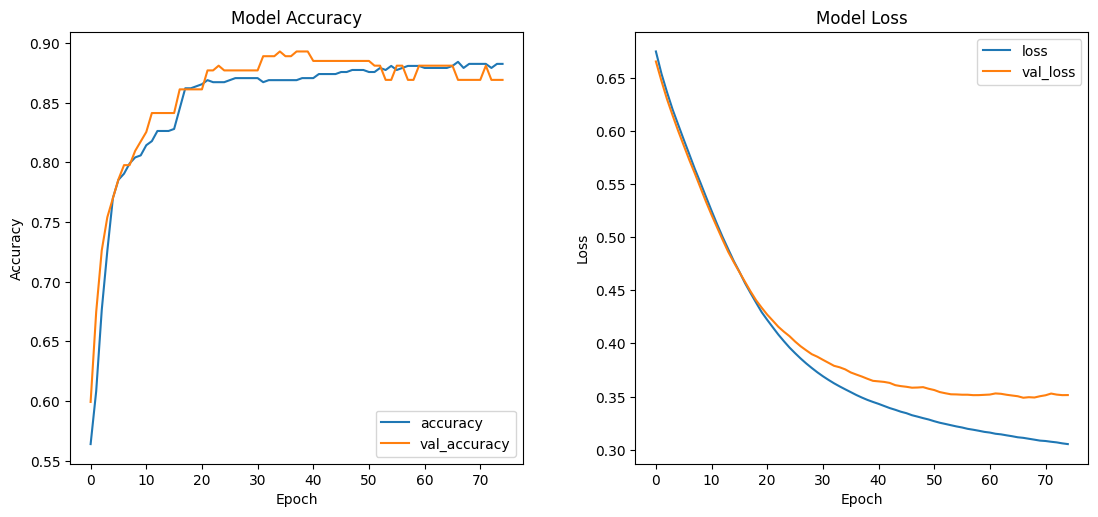

In [258]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
fig.tight_layout(pad=5)

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.legend(labels=["accuracy","val_accuracy"])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.legend(labels=["loss","val_loss"])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

From this model, we can see that the model accuracy is pretty high (>0.85) by the end of the epochs, but that loss ends up limiting around 0.35. There are also some signs of overfitting in the model loss as validation loss starts to be larger than training loss. Further valdiation is done below.

In [241]:
model2=Sequential([Dense(21,activation='relu'),Dense(1,activation='sigmoid')])
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),loss='binary_crossentropy',metrics='accuracy')
history2=model2.fit(x=x_train,y=y_train,batch_size=128,validation_data=(x_valid,y_valid),epochs=300,shuffle=True,verbose=0)

The second optimizer uses stochastic gradient descent, with a larger batch size, number of epochs, and learning rate, primarily since SGD converges more slowly. A larger batch size was also used since it tends to have noisier updates/variance. The intention was to try and find similar results to that of the Adam optimizer. 

Text(619.9949494949494, 0.5, 'Loss')

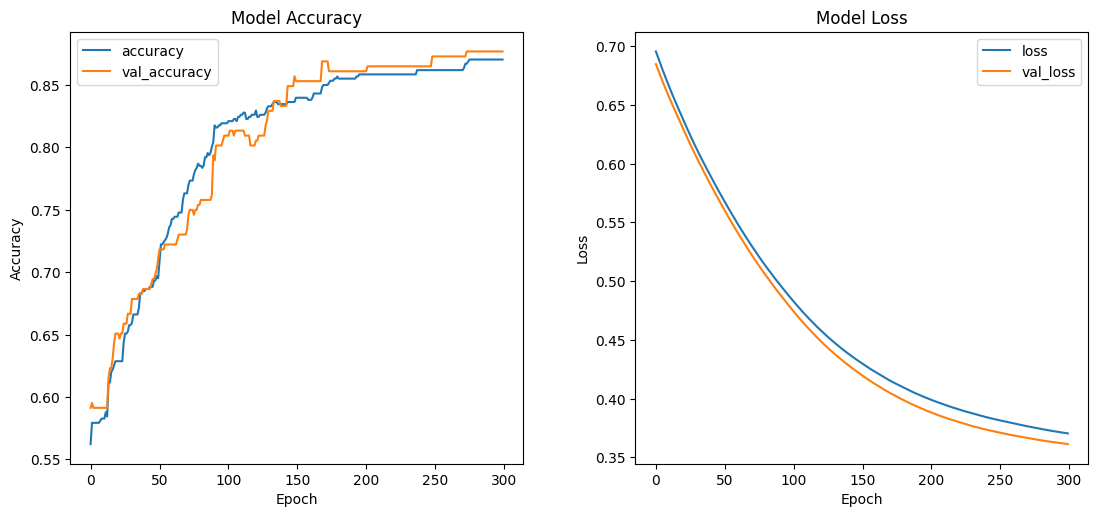

In [259]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
fig.tight_layout(pad=5)

ax1.plot(history2.history['accuracy'])
ax1.plot(history2.history['val_accuracy'])
ax1.legend(labels=["accuracy","val_accuracy"])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')

ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.legend(labels=["loss","val_loss"])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

In comparison to Adam, a similar accuracy and loss is reached, however, it takes many more epochs for SGD to reach a similar performance. It can also be seen that the validation loss and accuracy more closely follow the training model and accuracy, potentially indicating less issues with under/overfitting. Adaptive models (like Adam) can lead to overfitting, and typically don't generalize as well compared to non-adaptive counterparts [2]. 

## K-Fold Cross Validation

As suggested, 10-fold cross validation was done on both models, which splits the data into 10 groups and holds different secions as testing and training data. This type of validation helps to give insight on how the model generalizes on unseen data. This was done by adapting the code from: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md, which utilizes the sklearn library. Notably, the models were changed, and the loop was run for both models for each fold, as opposed to using one model. The models used the training data only, with the validation data used for further testing below to create a confusion matrix of the two models.

In [244]:
from sklearn.model_selection import KFold
num_folds=10
acc_per_fold = []
loss_per_fold = []
acc_per_fold2 =[]
loss_per_fold2=[]

kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1


for train, test in kfold.split(x_train, y_train):
    model=Sequential([Dense(21,activation='relu'),Dense(1,activation='sigmoid')])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics='accuracy')

    model2=Sequential([Dense(21,activation='relu'),Dense(1,activation='sigmoid')])
    model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),loss='binary_crossentropy',metrics='accuracy')

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history=model.fit(x=x_train,y=y_train,batch_size=64,validation_data=(x_valid,y_valid),epochs=75,shuffle=True,verbose=0) 
    history2=model2.fit(x=x_train,y=y_train,batch_size=128,validation_data=(x_valid,y_valid),epochs=300,shuffle=True,verbose=0)

    # returns info on loss and accuracy of models 
    # Adam
    scores = model.evaluate(x_train[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no} Adam: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # SGD
    scores2 = model2.evaluate(x_train[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no} SGD: {model2.metrics_names[0]} of {scores2[0]}; {model2.metrics_names[1]} of {scores2[1]*100}%')
    acc_per_fold2.append(scores2[1] * 100)
    loss_per_fold2.append(scores2[0])

    fold_no+= 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1 Adam: loss of 0.27544721961021423; accuracy of 88.13559412956238%
Score for fold 1 SGD: loss of 0.3183915615081787; accuracy of 88.13559412956238%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2 Adam: loss of 0.24678832292556763; accuracy of 89.83050584793091%
Score for fold 2 SGD: loss of 0.3231661915779114; accuracy of 86.44067645072937%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3 Adam: loss of 0.27274128794670105; accuracy of 86.44067645072937%
Score for fold 3 SGD: loss of 0.37809261679649353; accuracy of 86.44067645072937%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4 Adam: loss of 0.2792729139328003; accuracy of 88.13559412956238%
Score for fold 4 SGD: loss of 0.34219

In [248]:
print('--------------------------------------------------------------------------------------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Adam: Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})  \t > Loss: {np.mean(loss_per_fold)}')
print(f'> SGD: Accuracy: {np.mean(acc_per_fold2)} (+- {np.std(acc_per_fold2)}) \t > Loss: {np.mean(loss_per_fold2)}')
print('--------------------------------------------------------------------------------------------------------------------------------------------------------')

--------------------------------------------------------------------------------------------------------------------------------------------------------
Average scores for all folds:
> Adam: Accuracy: 87.55698382854462 (+- 2.468192580527371)  	 > Loss: 0.30847076177597044
> SGD: Accuracy: 85.33898293972015 (+- 3.123685141252676) 	 > Loss: 0.38626536130905154
--------------------------------------------------------------------------------------------------------------------------------------------------------


As shown by the results of 10-fold cross validation, the Adam optimizer has slightly better accuracy and loss, with less variance in the accuracy, however, this difference is minimal and is encompassed within the standard deviations of the two models. This gives some reassurance on the performance of the models. 

## Confusion Matrix

The validation data was then used below to create predictions using the two models to create a confusion matrix:

8/8 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'SGD Optimizer')

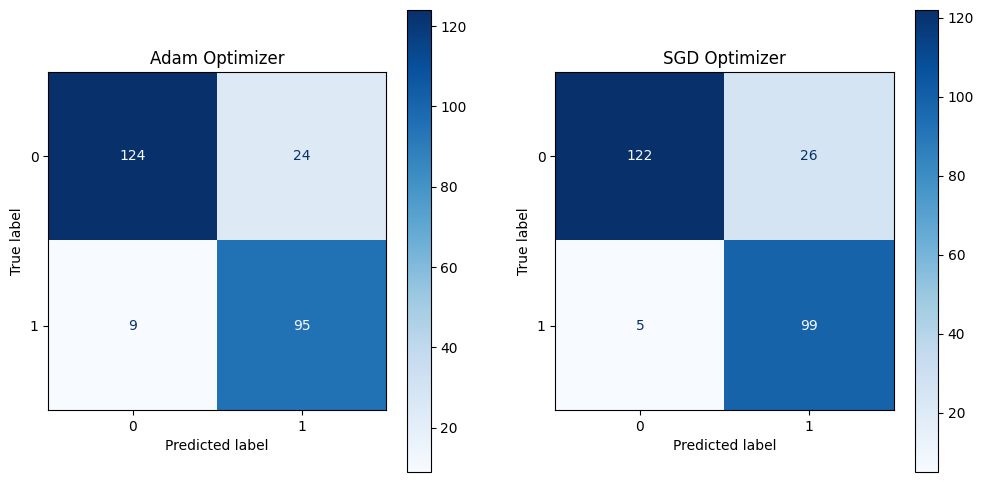

In [269]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# using validation data on just trained models to predict labels 
# >0.5 as int b/c last layer is sigmoid function
# Adam
pred=(model.predict(x_valid)>0.5).astype("int32")
cm=confusion_matrix(y_valid,pred)
#SGD
pred2=(model2.predict(x_valid)>0.5).astype("int32")
cm2=confusion_matrix(y_valid,pred2)

# plot
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax1,cmap='Blues')
ax1.set_title('Adam Optimizer')
ConfusionMatrixDisplay(confusion_matrix=cm2).plot(ax=ax2,cmap='Blues')
ax2.set_title('SGD Optimizer')

From the confusion matrix, the results are pretty comparable. LGG is correctly predicted by the Adam optimizer 84% of the time, compared to 82% for SGD, compared to 91% and 95% for CBM, respectively. This is expected from the results of the 10-fold cross validation.

### References
[1]	D. P. Kingma and J. Ba, “Adam: A Method for Stochastic Optimization.” arXiv, Jan. 29, 2017. Accessed: Apr. 20, 2024. [Online]. Available: http://arxiv.org/abs/1412.6980 <br>
[2]	A. C. Wilson, R. Roelofs, M. Stern, N. Srebro, and B. Recht, “The Marginal Value of Adaptive Gradient Methods in Machine Learning.” arXiv, May 21, 2018. Accessed: Apr. 20, 2024. [Online]. Available: http://arxiv.org/abs/1705.08292
